# **Prepare data**


In [ ]:
from google.colab import drive
import os

# gdrive_path='/content/gdrive/MyDrive/Bertopic/shared_work/'

# # This will mount your google drive under 'MyDrive'
# drive.mount('/content/gdrive', force_remount=True)
# # In order to access the files in this notebook we have to navigate to the correct folder
# os.chdir(gdrive_path)
# # Check manually if all files are present
# print(sorted(os.listdir()))
dataset_path = '/content/drive/MyDrive/Praktikum - NLP Applications/Datasets/genius_and_wasabi/'
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
pip install pandas bertopic

In [ ]:
pip install pandas nltk

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import nltk
nltk.download('wordnet') # to use wordnet

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
from nltk.corpus import wordnet as wn
# Find synsets for a word
synsets = wn.synsets('dog')
print(synsets)

[Synset('dog.n.01'), Synset('frump.n.01'), Synset('dog.n.03'), Synset('cad.n.01'), Synset('frank.n.02'), Synset('pawl.n.01'), Synset('andiron.n.01'), Synset('chase.v.01')]


In [ ]:
!pip install --upgrade tensorflow


In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
from umap import UMAP

# set path of the file
csv_file_path = 'chunk_5.csv'
df = pd.read_csv(dataset_path + csv_file_path)

# **Data Preprocessing**
This involves removing the explicit song structure from the lyrics column and initialising the CountVectorizer so that stop word removal is handled internally by BERTopic

In [ ]:
# Removing explicit song structure as it is not important information
import re

def remove_explicit_song_structure(lyrics):
  pattern = r'\[.+?\]'
  cleaned_lyrics = re.sub(pattern, '', lyrics)
  return cleaned_lyrics

df['cleaned_lyrics'] = df['lyrics'].astype(str).apply(remove_explicit_song_structure)
df.head()

Unnamed: 0                         title genre        artist  year  views  \
0          10  Dont Look Over Your Shoulder    rb  Nancy Wilson  1967     15   
1          11         This Mothers Daughter    rb  Nancy Wilson  1976    174   
2          12                       Changes    rb  Nancy Wilson  1977     15   
3          13             Patience My Child    rb  Nancy Wilson  1977     19   
4          14                        Nobody    rb  Nancy Wilson  1977     13   

  features                                             lyrics language  \
0       {}  Don't look\nDon't look\nDon't look\nDon't look...       en   
1       {}  [Verse 1]\nLies beyond her years\nThis mother'...       en   
2       {}  [Verse 1]\nIf you love me the way you say\nThi...       en   
3       {}  [Verse 1]\nWhen I was a youngster, I can recal...       en   
4       {}  [Verse 1]\nNobody knows me like you do\nNobody...       en   

   gender                                     cleaned_lyrics  
0  Female  Don't look\nDon't look\nDon't look\nDon't look...  
1  Female  \nLies beyond her years\nThis mother's daughte...  
2  Female  \nIf you love me the way you say\nThink about ...  
3  Female  \nWhen I was a youngster, I can recall\nSeekin...  
4  Female  \nNobody knows me like you do\nNobody feels my...

In [ ]:
# Initializing the CountVectorizer with English stop words to pass as a parameter to BERTopic
count_vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words="english")
# Initialising the UMAP constructor to set the random seed - this is so the results are reproducible

umap = UMAP(n_neighbors=15,
            n_components=5,
            min_dist=0.0,
            metric='cosine',
            low_memory=False,
            random_state=42)

# **Create Topics**
We select the "english" as the main language for our documents. If you want a multilingual model that supports 50+ languages, please select "multilingual" instead.

In [ ]:
# Fitting and saving the BERTopic model
model = BERTopic(vectorizer_model=count_vectorizer, language="english", umap_model=umap) #nr_topics=50 parameters find the most similar topics and merge them
model_path = '/content/drive/MyDrive/Praktikum - NLP Applications/Models'
df['has_lyrics'] = ~df['lyrics'].isna() # flag the rows that have lyrics
documents = df[df['has_lyrics']]['cleaned_lyrics'].astype(str).tolist()
#topics, _ = model.fit_transform(documents)

# Fitting BERTopic
topic_model = model.fit(documents)
# Saving it using safetensors
# embedding_model = "sentence-transformers/all-MiniLM-L6-v2"
# topic_model.save(model_path, serialization="safetensors", save_ctfidf=True, save_embedding_model=embedding_model)

In [ ]:
# Saving it using safetensors
embedding_model = "sentence-transformers/all-MiniLM-L6-v2"
model.save(model_path, serialization="safetensors", save_ctfidf=True, save_embedding_model=embedding_model)

 If you are loading a pre-trained model, you should use transform() instead of fit_transform() to get the topics for new documents or fit_transform() if you are updating the model with new documents.

In [ ]:
loaded_model = BERTopic.load("/content/drive/MyDrive/Praktikum - NLP Applications/Models")
topics, prob = loaded_model.transform(documents)
print(topics)

[ 22   9   2 ...  15  46 159]


***To measure gender bias per topic in a dataset using BERTopic and WEAT (Word Embedding Association Test), you need to follow a series of steps. These include topic modeling with BERTopic, creating target and attribute word sets for WEAT, and then performing the WEAT analysis for each topic. To integrate WEAT analysis with BERTopic, you need a separate word embeddings model.***

Step 1 Analyzing topic distribution across genders

In [ ]:
# Checking what kind of labels are returned
topic_labels = loaded_model.generate_topic_labels()
topic_labels

['-1_im_love_dont',
 '0_jesus_lord_praise',
 '1_dance_party_shake',
 '2_feel_things_change',
 '3_christmas_santa_merry',
 '4_mi_yuh_di',
 '5_niggas_nigga_shit',
 '6_bye bye_bye_country',
 '7_america_people_war',
 '8_tae_ye_young',
 '9_shes_shes got_fighting fighting',
 '10_shes_shell_shes hair',
 '11_sea_sail_ship',
 '12_bitch_ayy_bag',
 '13_baby_love_deeper',
 '14_blues_blue_mr blue',
 '15_fight fight_fight_way feels',
 '16_loo_loo loo_money',
 '17_lawd_lawd lawd_indian',
 '18_ghost town_ahahah_falls',
 '19_christ_bethlehem_let adore',
 '20_dream_thousand light_yes yes',
 '21_woman_man_need man',
 '22_love_hearts_heart',
 '23_away far_far away_far',
 '24_nigga_niggas_stove',
 '25_angel_youre angel_angels',
 '26_youve gone_id_falling eyes',
 '27_fool_slipped_slipped tripped',
 '28_willow_willow weep_weep',
 '29_pretty_pretty woman_woman',
 '30_lyrics snippet_snippet_lyrics',
 '31_goodbye_miss jones_dont way',
 '32_kiss_forbidden love_heart soul',
 '33_la la_la_lalalalalala',
 '34_moon_

In [ ]:
# Visualizing the intertopic distance

loaded_model.visualize_topics()

In [ ]:
# Visualizing the topic similarities

loaded_model.visualize_heatmap()

In [ ]:
loaded_model.visualize_barchart()

we can also reduce the number of topics after having trained a BERTopic model. The advantage of doing so is that you can decide the number of topics after knowing how many are created. It is difficult to predict before training your model how many topics that are in your documents and how many will be extracted. Instead, we can decide afterward how many topics seem realistic:

In [ ]:
def generate_topic_label_dictionary():
  topic_label_dictionary = {}
  topic_label_list = [{label.split('_')[0]: label.split('_', 1)[1]} for label in topic_labels]

  for item in topic_label_list:
    topic_label_dictionary.update(item)
  return topic_label_dictionary

topic_label_dictionary = generate_topic_label_dictionary()
print(topic_label_dictionary)

{'-1': 'im_love_dont', '0': 'jesus_lord_praise', '1': 'dance_party_shake', '2': 'feel_things_change', '3': 'christmas_santa_merry', '4': 'mi_yuh_di', '5': 'niggas_nigga_shit', '6': 'bye bye_bye_country', '7': 'america_people_war', '8': 'tae_ye_young', '9': 'shes_shes got_fighting fighting', '10': 'shes_shell_shes hair', '11': 'sea_sail_ship', '12': 'bitch_ayy_bag', '13': 'baby_love_deeper', '14': 'blues_blue_mr blue', '15': 'fight fight_fight_way feels', '16': 'loo_loo loo_money', '17': 'lawd_lawd lawd_indian', '18': 'ghost town_ahahah_falls', '19': 'christ_bethlehem_let adore', '20': 'dream_thousand light_yes yes', '21': 'woman_man_need man', '22': 'love_hearts_heart', '23': 'away far_far away_far', '24': 'nigga_niggas_stove', '25': 'angel_youre angel_angels', '26': 'youve gone_id_falling eyes', '27': 'fool_slipped_slipped tripped', '28': 'willow_willow weep_weep', '29': 'pretty_pretty woman_woman', '30': 'lyrics snippet_snippet_lyrics', '31': 'goodbye_miss jones_dont way', '32': 'kis

In [ ]:
new_nr_topics = 5  # the new desired number of topics
loaded_model.reduce_topics(documents, nr_topics=new_nr_topics)
# merge the topic based on their similarity based on the distance between their centroids in the embedding space.

In [ ]:
topics = loaded_model.topics_
len(topics)
topic_labels = loaded_model.generate_topic_labels()
topic_labels

['-1_love_don_oh',
 '0_oh_love_like',
 '1_catalog_product_app',
 '2_boris_brexit_british',
 '3_feels like_feels_girl']

In [ ]:
# Fit BERTopic
# documents = df[df['has_lyrics']]['cleaned_lyrics'].astype(str).tolist()
df.loc[~df['has_lyrics'], 'topic'] = "No Lyrics"  # e.g., -1 or "No Lyrics"
# Assign topics only to rows where 'has_lyrics' is True
df.loc[df['has_lyrics'], 'topic'] = topics

In [ ]:
loaded_model.visualize_topics()

In [ ]:
loaded_model.visualize_heatmap()

In [ ]:
# Group by topics and gender, and count occurrences, aggregate lyrices by topic and gender
topic_gender_distribution = df.groupby(['topic', 'gender']).size().unstack(fill_value=0)

#  normalize the counts to compare proportions rather than raw counts
topic_gender_distribution_normalized = topic_gender_distribution.div(topic_gender_distribution.sum(axis=1), axis=0)

In [ ]:
# Aggregate lyrics by topic and gender, groups the DataFrame by topic and gender and then concatenates all lyrics within each group.
aggregated_lyrics = df.groupby(['topic', 'gender'])['lyrics'].apply(lambda x: ' '.join(x)).reset_index()
# Extract embeddings for each group
embeddings = loaded_model._extract_embeddings(documents) # not recommended to use this method since it is an internal method and its use is not for standard operations, this functions also use internal sentence transformers

In [ ]:
df['embedding'] = list(embeddings)

 Extract and Analyze Top Words per Topic-Gender Group
For each topic and gender group, extract the most representative words. These words will be used to measure bias.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_words(text, n=20):
    vec = CountVectorizer(stop_words='english').fit([text])
    bag_of_words = vec.transform([text])
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]
aggregated_lyrics['top_words'] = aggregated_lyrics['lyrics'].apply(lambda x: get_top_words(x))

Now in this section we will analyze the top words by genre

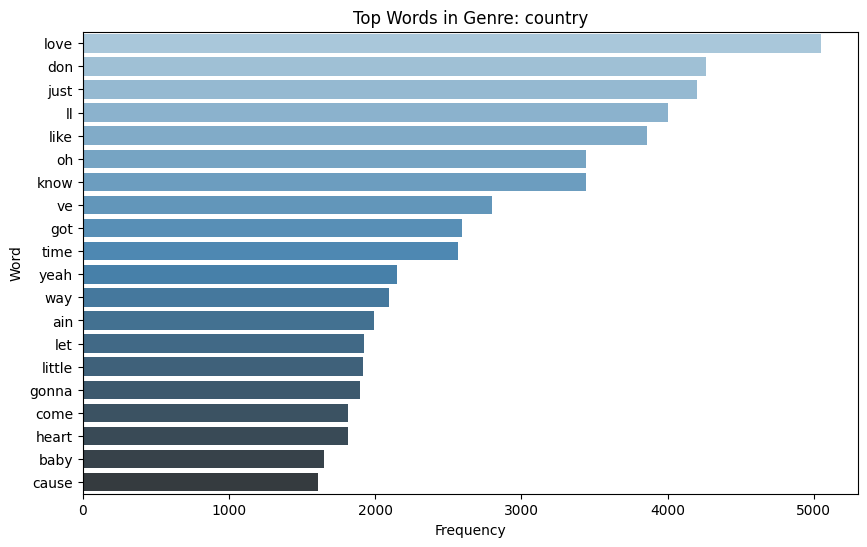

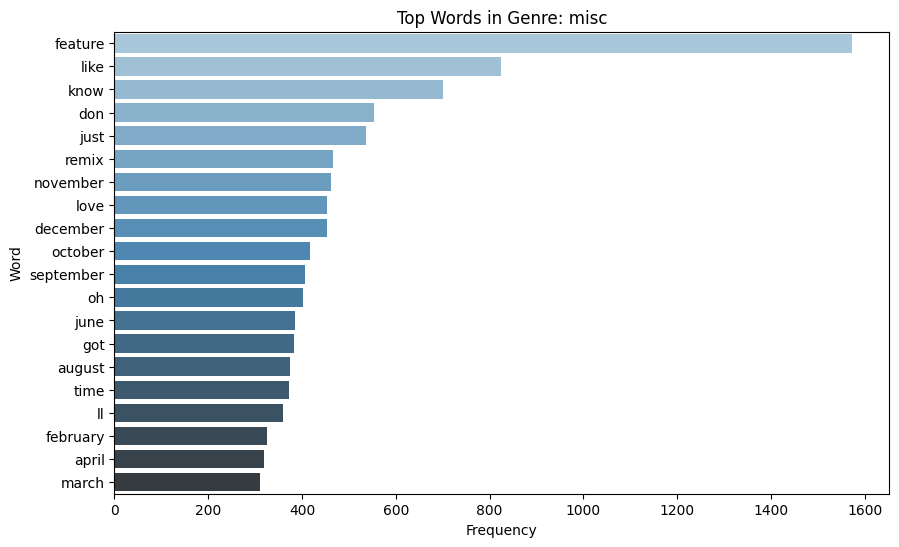

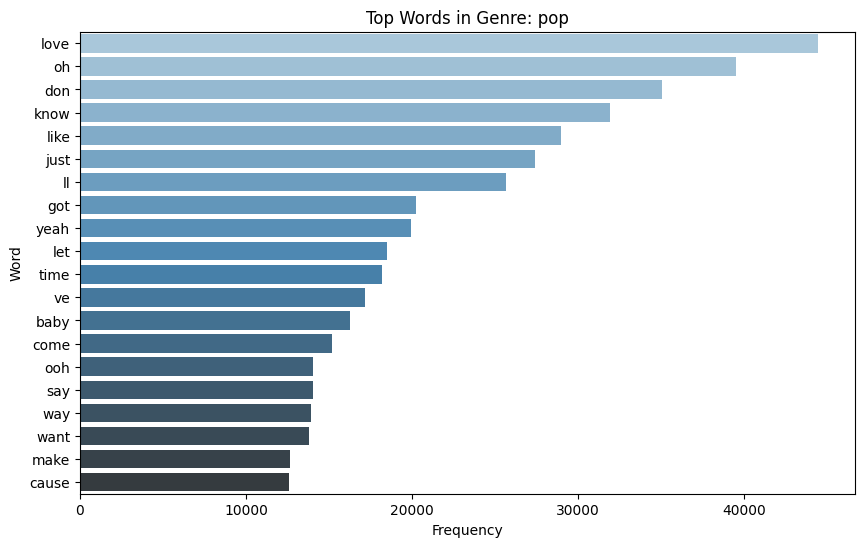

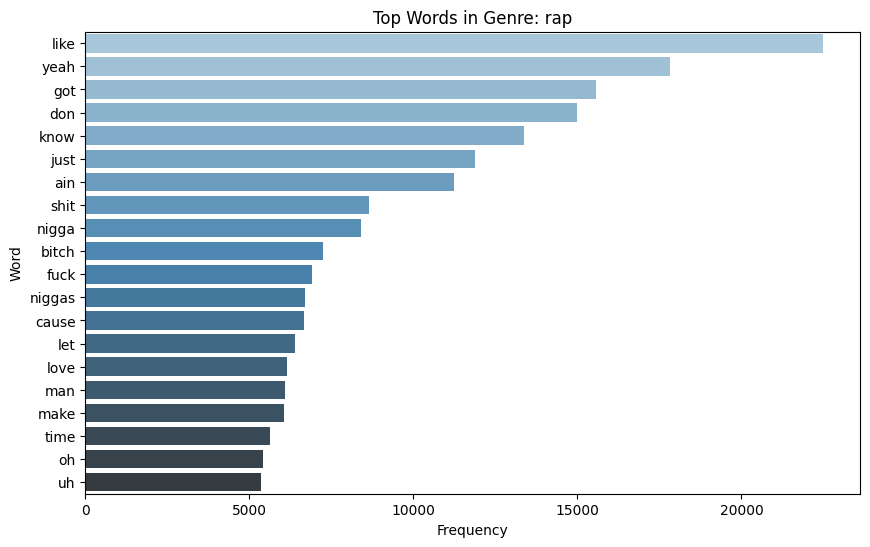

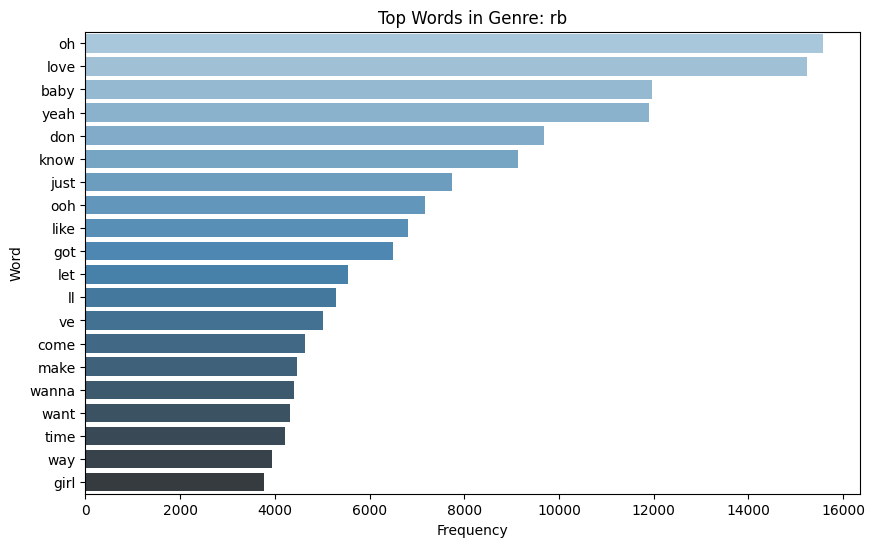

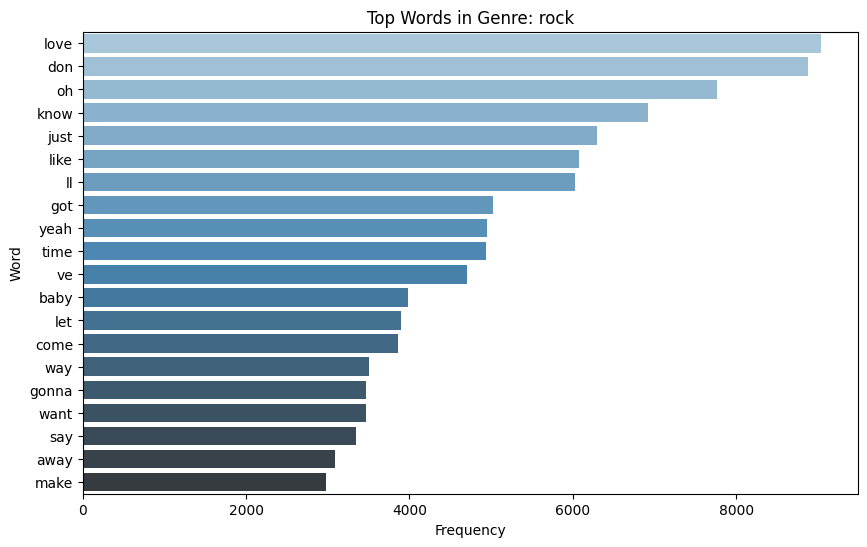

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

# Combine all lyrics per genre into a single string
genre_lyrics = df.groupby('genre')['cleaned_lyrics'].apply(lambda x: ' '.join(x))

# Get the top words for each genre
genre_top_words = genre_lyrics.apply(lambda x: get_top_words(x))

# Create a bar chart for the top words per genre
for genre, top_words in genre_top_words.iteritems():
    # Unpack words and their frequencies
    words, freqs = zip(*top_words)

    # Create DataFrame for plotting
    plot_data = pd.DataFrame({'Word': words, 'Frequency': freqs})

    # Plot the data using seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Frequency', y='Word', data=plot_data, palette='Blues_d')
    plt.title(f'Top Words in Genre: {genre}')
    plt.show()


collect top topic first an then analyze the top words per genre
It first finds the most frequent topic for each genre.
Then, it aggregates the lyrics of all documents in each genre that belong to this most frequent topic.
For these aggregated lyrics, it extracts the top words.
Finally, it visualizes these top words in a bar chart for each genre.


Genre: country
Top Topic: -1 (Frequency: 2397)
 im_love_dont


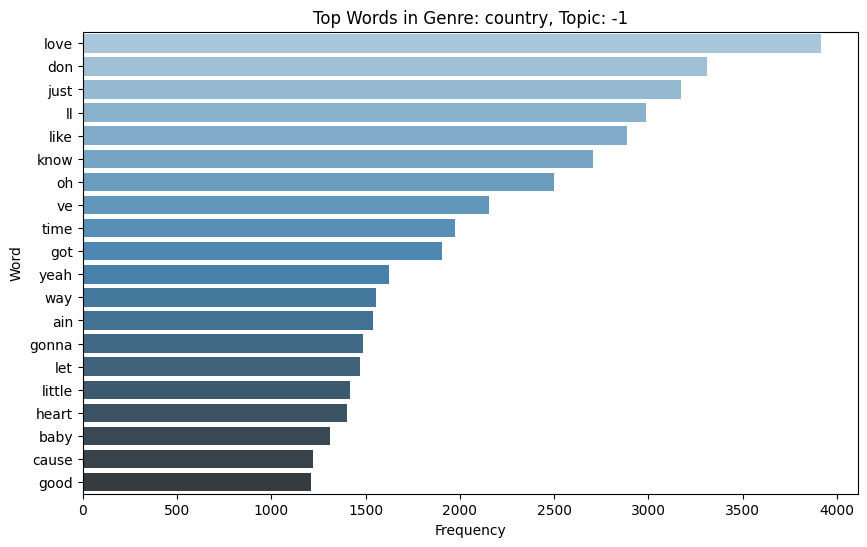


Genre: misc
Top Topic: -1 (Frequency: 320)
 im_love_dont


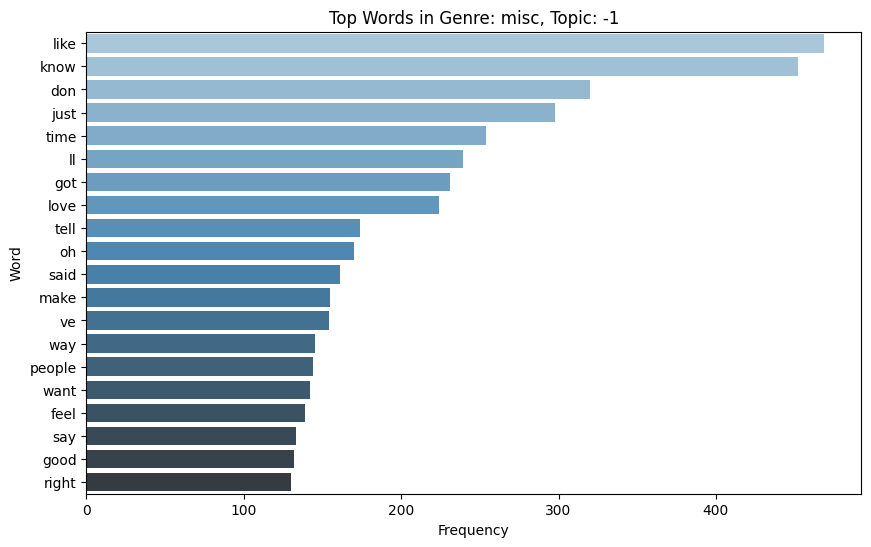


Genre: pop
Top Topic: -1 (Frequency: 15704)
 im_love_dont


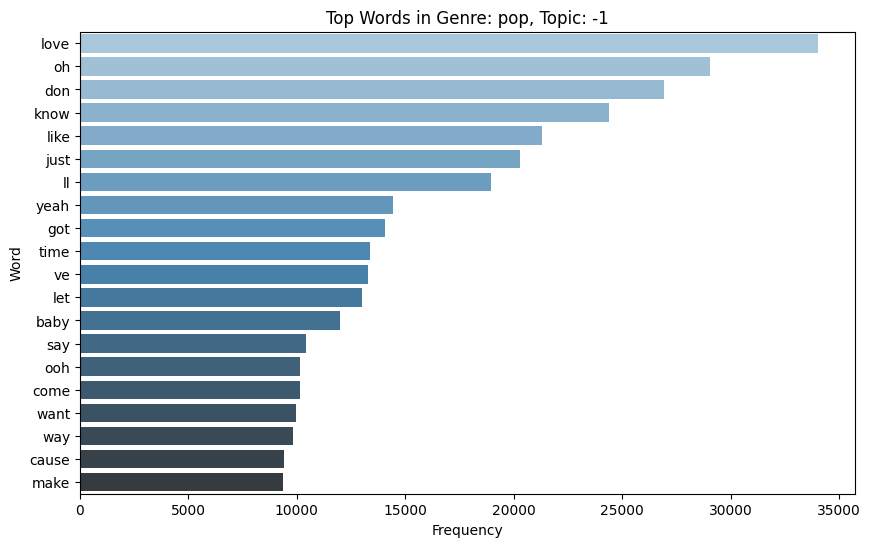


Genre: rap
Top Topic: -1 (Frequency: 3934)
 im_love_dont


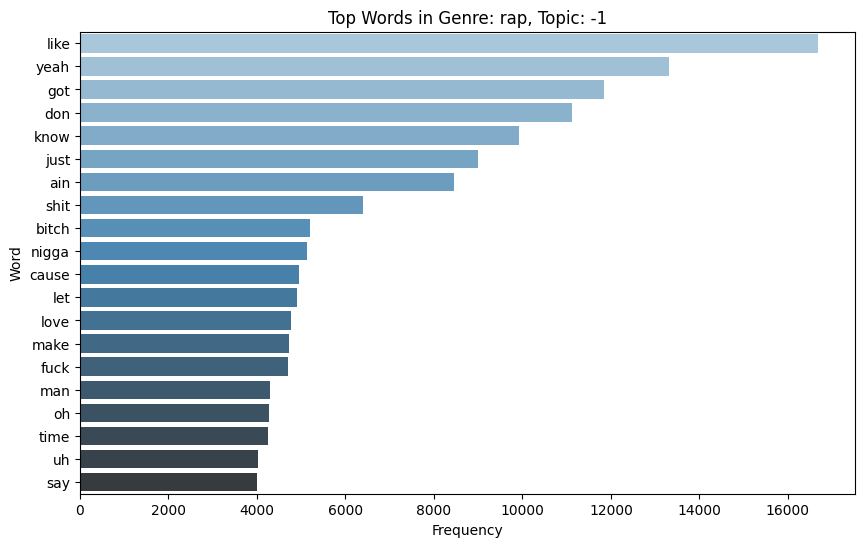


Genre: rb
Top Topic: -1 (Frequency: 2747)
 im_love_dont


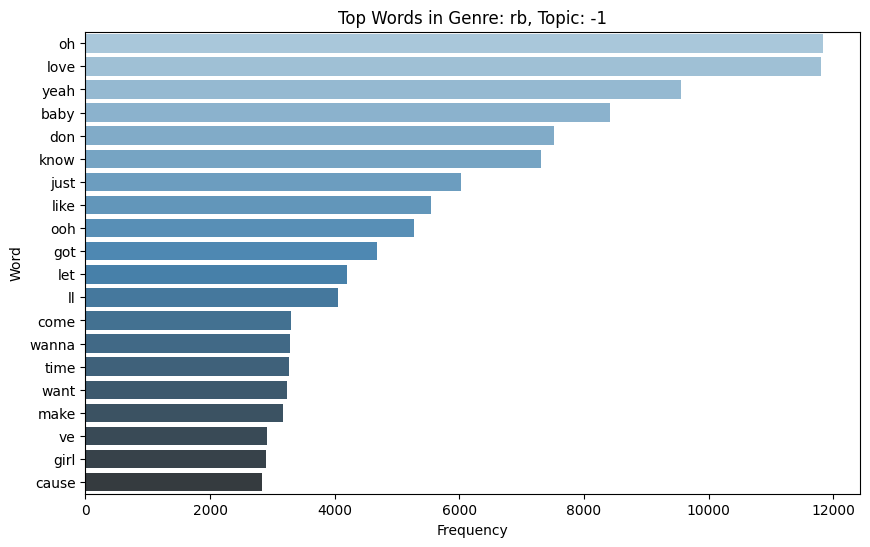


Genre: rock
Top Topic: -1 (Frequency: 4790)
 im_love_dont


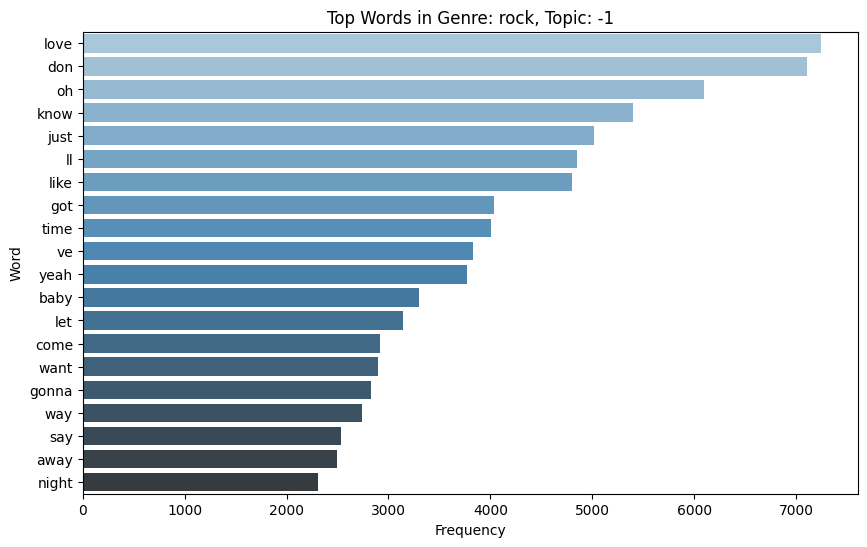

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

# Function to get the most frequent topic and its frequency for each genre
def get_most_frequent_topic(df):
    topic_counts = df['topic'].value_counts()
    most_frequent_topic = topic_counts.idxmax()
    frequency = topic_counts.max()
    return most_frequent_topic, frequency

# Group by genre and get the most frequent topic for each genre
genre_most_frequent_topic = df.groupby('genre').apply(get_most_frequent_topic)

# For each genre, filter the documents belonging to the most frequent topic
genre_specific_documents = {
    genre: " ".join(df[(df['genre'] == genre) & (df['topic'] == topic[0])]['cleaned_lyrics'])
    for genre, topic in genre_most_frequent_topic.items()
}

# Function to get top n words from a given text
def get_top_words(text, n=20):
    vec = CountVectorizer(stop_words='english').fit([text])
    bag_of_words = vec.transform([text])
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Get the top words for the most frequent topic in each genre
genre_top_words = {
    genre: get_top_words(documents, 20)
    for genre, documents in genre_specific_documents.items()
}

# Visualize the top words and print top topic info for the most frequent topic in each genre
for genre, top_words in genre_top_words.items():
    # Most frequent topic and its frequency
    topic, freq = genre_most_frequent_topic[genre]
    print(f"\nGenre: {genre}\nTop Topic: {topic} (Frequency: {freq})\n {topic_label_dictionary[str(topic)]}")

    # Top words in the topic
    words, freqs = zip(*top_words)

    # Create DataFrame for plotting
    plot_data = pd.DataFrame({'Word': words, 'Frequency': freqs})

    # Plot the data using seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Frequency', y='Word', data=plot_data, palette='Blues_d')
    plt.title(f'Top Words in Genre: {genre}, Topic: {topic}')
    plt.show()



Top 5 Topics for the genre: country
 Topic  Count                    Name                                         Representation                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

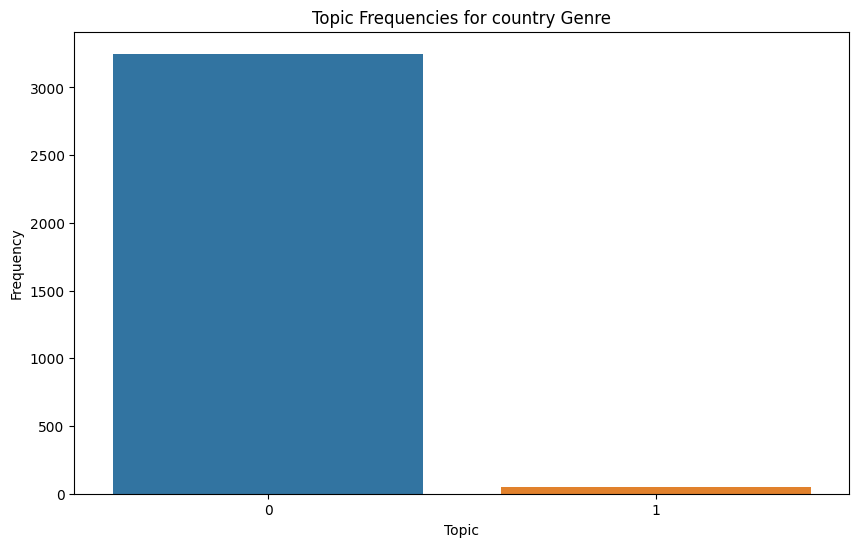

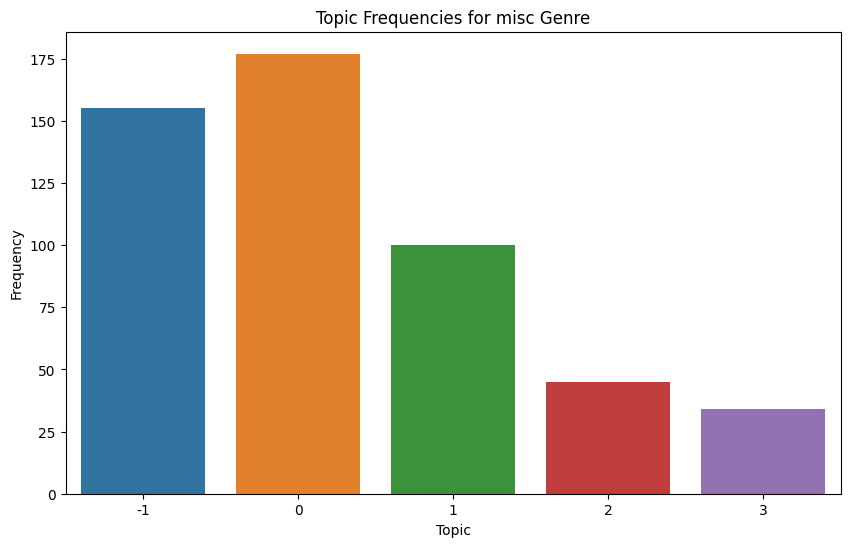

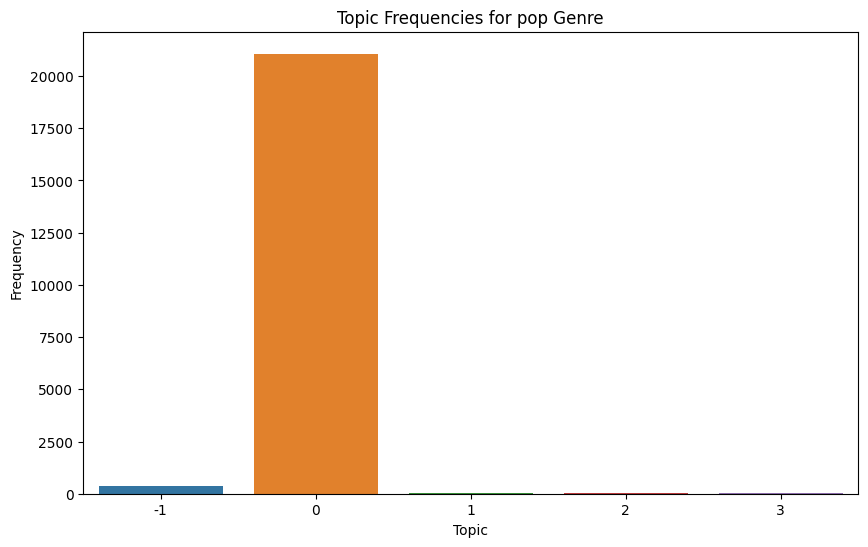

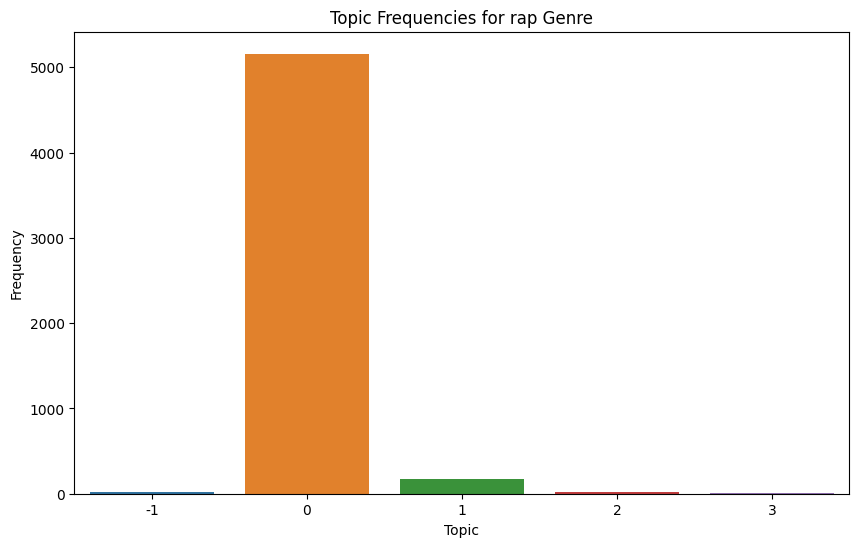

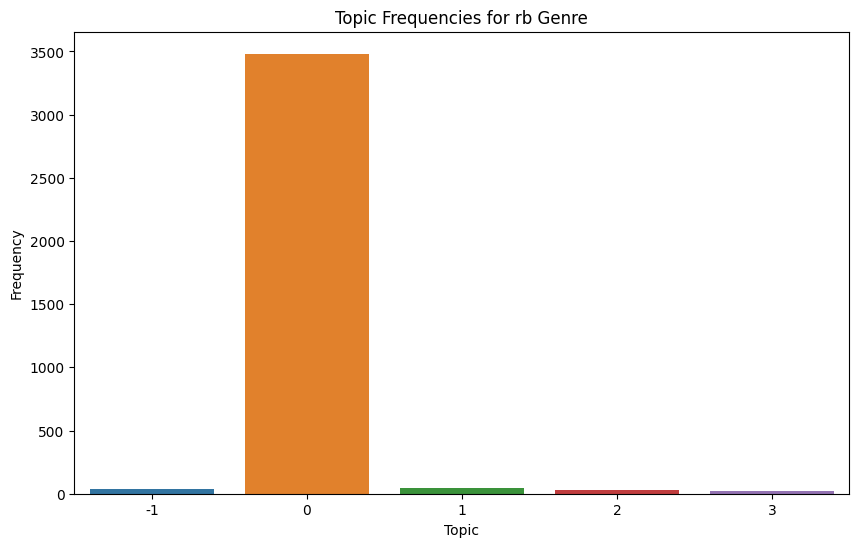

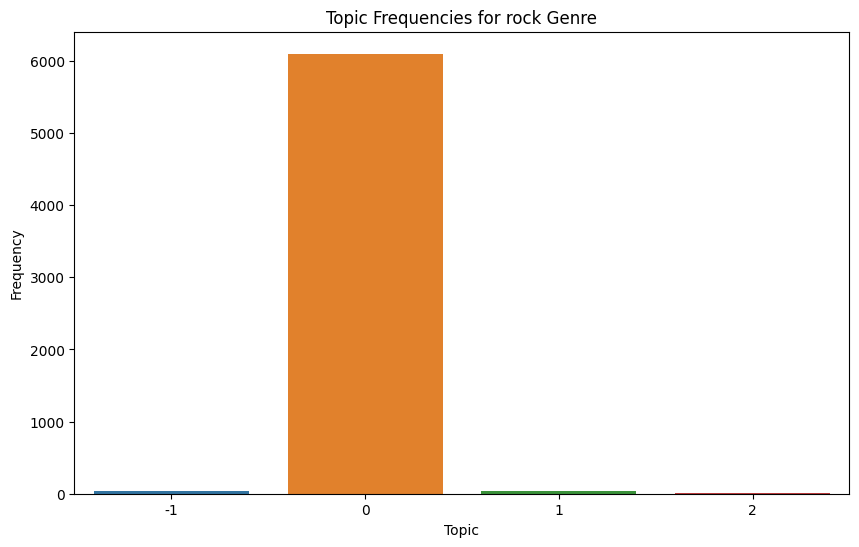

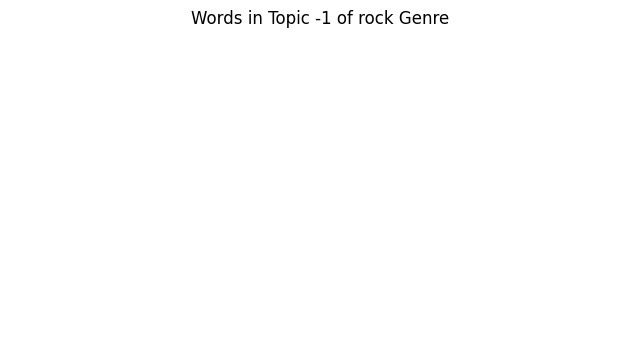

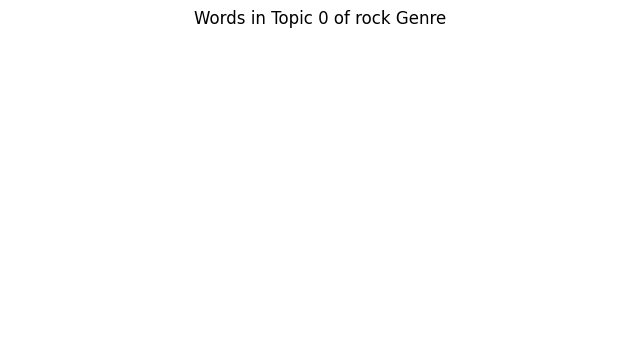

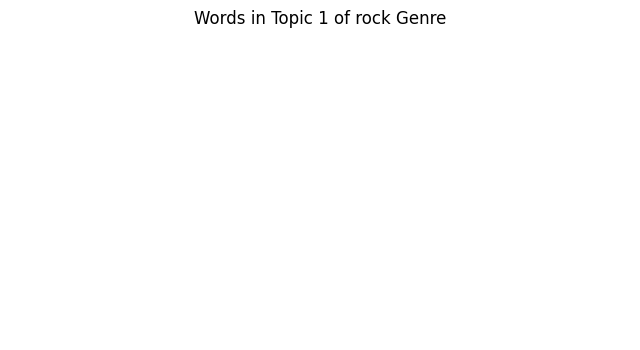

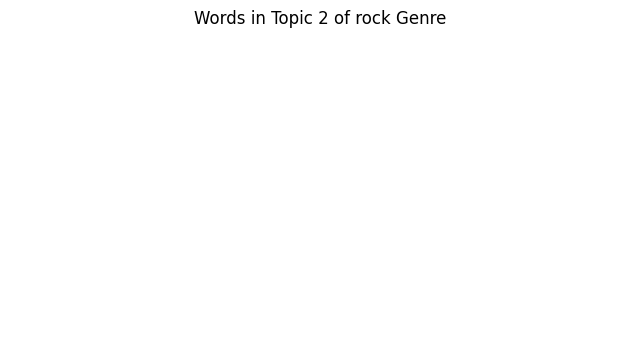

In [ ]:
import matplotlib.pyplot as plt

genre_most_frequent_topic = df.groupby('genre')['cleaned_lyrics'].apply(list)

genre_topics = {}

# Find top topics for each genre
for genre, lyrics in genre_most_frequent_topic.items():
        # Fit the BERTopic model on the lyrics of the current genre
        current_model = BERTopic(nr_topics="auto")  # Adjust parameters as needed
        current_model.fit(lyrics)

        # Get the topic info
        topic_info = current_model.get_topic_info()

        # Convert topic_info to DataFrame and get the top topics
        topic_df = pd.DataFrame(topic_info).head(5)  # Limit to top 5 topics

        # Store the DataFrame in the dictionary
        genre_topics[genre] = topic_df

# Print out the top 5 topic information for each genre in a table format
for genre, topic_df in genre_topics.items():
    print(f"Top 5 Topics for the genre: {genre}")
    print(topic_df.to_string(index=False))
    print("\n")  # Add a newline for spacing between decades

# Step 1: Bar Charts for Topic Frequency
for genre, topic_df in genre_topics.items():
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Topic', y='Count', data=topic_df)
    plt.title(f'Topic Frequencies for {genre} Genre')
    plt.xlabel('Topic')
    plt.ylabel('Frequency')
    plt.show()

for index, row in topic_df.iterrows():
    topic = row['Topic']
    words = row['Name'].split('_')

#    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(words))

    plt.figure(figsize=(8, 4))
 #   plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Words in Topic {topic} of {genre} Genre')
    plt.show()

Now we analyze the top 5 topic on a per decade basis, bear in mind that this can be extremely resource intensive for larger dataset(for example if in the futture we are running the chunks together)

In [ ]:
import pandas as pd

# Function to assign the decade to each song based on its year
def assign_decade(year):
    return (year // 10) * 10

# Assign decade to each song
df['decade'] = df['year'].apply(assign_decade)

# Group the data by decade
grouped_by_decade = df.groupby('decade')['cleaned_lyrics'].apply(list)

decade_topics = {}

# Find top 5 topics for each decade
for decade, lyrics in grouped_by_decade.items():
    # Check if the number of documents is sufficient
    if len(lyrics) < 5:  # min 3 of data point each decades must have to avoid dimensionality reduction issue
        print(f"Skipping decade {decade} due to insufficient data.")
        continue

    try:
        # Fit the BERTopic model on the lyrics of the current decade
        current_model = BERTopic(nr_topics="auto")  # Adjust parameters as needed
        current_model.fit(lyrics)

        # Get the topic info
        topic_info = current_model.get_topic_info()

        # Convert topic_info to DataFrame and get the top 5 topics
        topic_df = pd.DataFrame(topic_info).head(5)  # Limit to top 5 topics

        # Store the DataFrame in the dictionary
        decade_topics[decade] = topic_df
    except Exception as e:
        print(f"An error occurred for decade {decade}: {e}")
        continue

# Print out the top 5 topic information for each decade in a table format
for decade, topic_df in decade_topics.items():
    print(f"Top 5 Topics for the decade: {decade}")
    print(topic_df.to_string(index=False))
    print("\n")  # Add a newline for spacing between decades


/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1600: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.

/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1600: RuntimeWarning:

k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.



An error occurred for decade 0: Cannot use scipy.linalg.eigh for sparse A with k >= N. Use scipy.linalg.eigh(A.toarray()) or reduce k.
Skipping decade 30 due to insufficient data.
Skipping decade 1210 due to insufficient data.
Skipping decade 1530 due to insufficient data.
Skipping decade 1820 due to insufficient data.
Skipping decade 1900 due to insufficient data.
Skipping decade 1910 due to insufficient data.
Top 5 Topics for the decade: 1920
 Topic  Count             Name                                               Representation                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [ ]:
pip install numpy gensim

In [ ]:
pip install matplotlib seaborn

Cosine Similarity: This function computes the cosine similarity between two word embeddings.

Mean Embedding Similarity: This function computes the average cosine similarity between each word in a target set and an attribute set.

Differential Association: This calculates the WEAT score, which is the differential association between two sets of target words and two sets of attribute words.

WEAT Effect Size: This calculates the effect size, a measure of how large the difference in associations is.

Target and Attribute Sets: You need to define these sets based on your specific analysis goal.

Target words are typically chosen to represent two different groups that you want to compare for bias. WEAT calculates how strongly each set of target words is associated with each set of attribute words. If one set of target words is more closely associated with positive attribute words (e.g., 'joy', 'peace', 'love') than the other, this might indicate a bias in the embedding space.Quantitative Analysis: The strength of these associations is quantified using cosine similarity in the embedding space. This provides a numerical measure of bias, which is the WEAT score.

In [ ]:
!wget -c "http://nlp.stanford.edu/data/glove.6B.zip"
!unzip glove.6B.zip
from gensim.scripts.glove2word2vec import glove2word2vec

glove_input_file = 'glove.6B.100d.txt'  # Adjust the file name as needed
word2vec_output_file = 'glove.6B.100d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

--2024-01-10 17:27:23--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-01-10 17:27:24--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-01-10 17:27:24--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

<ipython-input-61-6ce0bcdfbacc>:7: DeprecationWarning:

Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).



(400000, 100)

if you want to display the topics as words instead of numeric labels in your WEAT analysis. you need to map the numeric topic labels to their corresponding words. You can achieve this by creating a mapping dictionary that associates each topic label with a list of words representing that topic.

In [ ]:
from gensim.models import KeyedVectors

word_embeddings_model = KeyedVectors.load_word2vec_format('glove.6B.100d.txt.word2vec', binary=False)

attribute sets

In [ ]:
male_words = ['he', 'him', 'his', 'father', 'papa', 'dad', 'son', 'uncle', 'grandfather', 'grandpa', 'man', 'male', 'brother', 'husband', 'boyfriend', 'sir', 'king', 'guy', 'father-in-law', 'son-in-law', 'nephew', 'boy']
female_words = ['she', 'her', 'hers', 'mother', 'mama', 'daughter', 'aunt', 'auntie', 'grandmother', 'woman', 'female', 'sister', 'mom', 'wife', 'girlfriend', 'madam', 'queen', 'gal', 'niece', 'grandmother-in-law', 'daughter-in-law', 'lady', 'miss', 'sis', 'girl']

#This variable is supposed to represent another set of attribute words for the WEAT analysis, serving as a basis for comparison against the attribute words extracted from each topic.
male_words = [word for word in male_words if word in word_embeddings_model.key_to_index]
female_words = [word for word in female_words if word in word_embeddings_model.key_to_index]

In [ ]:
import numpy as np
from gensim.models import KeyedVectors
from nltk.corpus import wordnet as wn

import numpy as np
from nltk.corpus import wordnet as wn

# Ensure you have downloaded the necessary NLTK data
import nltk
nltk.download('wordnet')

def cosine_similarity(embedding1, embedding2):
    norm1 = np.linalg.norm(embedding1)
    norm2 = np.linalg.norm(embedding2)
    return np.dot(embedding1, embedding2) / (norm1 * norm2)

def get_concept_words(word):
    synsets = wn.synsets(word)
    return [lemma.name().replace('_', ' ') for synset in synsets for lemma in synset.lemmas() if synset.pos() in {'n', 'v'}]

def flatten(list_of_lists):
    return [item for sublist in list_of_lists for item in sublist]

def average_embedding(words, embeddings_model):
    valid_embeddings = [embeddings_model[word] for word in words if word in embeddings_model.key_to_index]
    return np.mean(valid_embeddings, axis=0) if valid_embeddings else np.zeros(embeddings_model.vector_size)

# SC-WEAT effect size calculation function with concept words for the target set
def sc_weat_effect_size_target_concepts(target_words, male_words, female_words, embeddings_model):
    # Generate concept words for the target set
    target_concepts = flatten([get_concept_words(word) for word in target_words]) # These concept words are synonyms or semantically related words. The flatten function is used to convert a list of lists into a single flattened list.

    # Calculate average embeddings for male and female attribute sets
    male_avg_embedding = average_embedding(male_words, embeddings_model)
    female_avg_embedding = average_embedding(female_words, embeddings_model)

    diffs = []
    for target_concept in target_concepts:
        if target_concept in embeddings_model.key_to_index:
            target_embedding = embeddings_model[target_concept]
            diff = cosine_similarity(target_embedding, male_avg_embedding) - \
                   cosine_similarity(target_embedding, female_avg_embedding)
            diffs.append(diff)
            #how similar the concept word is to the average male words compared to the average female words.
    effect_size = np.mean(diffs) / np.std(diffs) if diffs else 0  #mean of these differences divided by their standard deviation.
    return effect_size
# A positive effect size suggests that the concept words associated with a topic are more closely
# related to the male words than to the female words. This could indicate a male-gendered bias in the context of that topic.


def print_sc_weat_results(topic, score):
    print(f"Topic: {topic}")
    print(f"  SCWEAT effect: {score}")
    print("")

# Define your target and attribute word sets
male_words = [word for word in male_words if word in word_embeddings_model.key_to_index]
female_words = [word for word in female_words if word in word_embeddings_model.key_to_index]

# Create a mapping dictionary to associate topic labels with words
topic_words_mapping = {}
sc_weat_results = []

for topic_label in aggregated_lyrics['topic'].unique():
    # Logic to obtain top words for each topic
    top_words = aggregated_lyrics[(aggregated_lyrics['topic'] == topic_label)]['top_words'].tolist()
    top_words = flatten(top_words)
    top_words_cleared = [item[0] for item in top_words]
    topic_words_mapping[topic_label] = top_words_cleared
    target_set=top_words_cleared

    if target_set:
        effect_size = sc_weat_effect_size_target_concepts(target_set, male_words, female_words, word_embeddings_model)
        print_sc_weat_results(topic_label_dictionary[str(topic_label)],  effect_size)
        sc_weat_results.append({
            "topic_number": str(topic_label),
            "topic_label": topic_label,
            "effect_size": effect_size,
        })
    else:
        print(f"Topic {topic} - Not enough data for SC-WEAT analysis")

Topic: im_love_dont
  SCWEAT effect: 0.6810933947563171

Topic: jesus_lord_praise
  SCWEAT effect: 0.6561858654022217

Topic: dance_party_shake
  SCWEAT effect: 0.7490842938423157

Topic: feel_things_change
  SCWEAT effect: 0.801524817943573

Topic: christmas_santa_merry
  SCWEAT effect: 0.0037674715276807547



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Analysis words across topic (not concept words), there could be words that is relevant to multiple topics. compare the amount of bias between topic

In [ ]:
def sc_weat_score_word(word, male_words, female_words, embeddings_model):
    if word not in embeddings_model.key_to_index:
        return None  # Word not in embeddings model

    word_embedding = embeddings_model[word]
    male_avg_embedding = average_embedding(male_words, embeddings_model)
    female_avg_embedding = average_embedding(female_words, embeddings_model)

    score = cosine_similarity(word_embedding, male_avg_embedding) - \
            cosine_similarity(word_embedding, female_avg_embedding)
    return score

# Create a dictionary to store SCWEAT scores for each word across topics
word_scweat_scores = {}

for topic_label, top_words in topic_words_mapping.items():
    for word in top_words:
        scweat_score = sc_weat_score_word(word, male_words, female_words, word_embeddings_model)
        if scweat_score is not None:
            if word not in word_scweat_scores:
                word_scweat_scores[word] = {}
            word_scweat_scores[word][topic_label] = scweat_score

# Print out the SCWEAT scores for each word across topics
for word, scores in word_scweat_scores.items():
    print(f"Word: '{word}'")
    for topic_label, score in scores.items():
        topic_name = topic_label_dictionary.get(str(topic_label), "Unknown Topic")
        print(f"  Topic: '{topic_name}' - SCWEAT Score: {score:.2f}")
    print("")



Word: 'love'
  Topic: 'im_love_dont' - SCWEAT Score: -0.04
  Topic: 'jesus_lord_praise' - SCWEAT Score: -0.04
  Topic: 'christmas_santa_merry' - SCWEAT Score: -0.04

Word: 'oh'
  Topic: 'im_love_dont' - SCWEAT Score: -0.02
  Topic: 'jesus_lord_praise' - SCWEAT Score: -0.02
  Topic: 'feel_things_change' - SCWEAT Score: -0.02

Word: 'chorus'
  Topic: 'im_love_dont' - SCWEAT Score: -0.05
  Topic: 'jesus_lord_praise' - SCWEAT Score: -0.05
  Topic: 'feel_things_change' - SCWEAT Score: -0.05
  Topic: 'christmas_santa_merry' - SCWEAT Score: -0.05

Word: 'don'
  Topic: 'im_love_dont' - SCWEAT Score: 0.20
  Topic: 'jesus_lord_praise' - SCWEAT Score: 0.20
  Topic: 'feel_things_change' - SCWEAT Score: 0.20
  Topic: 'christmas_santa_merry' - SCWEAT Score: 0.20

Word: 'know'
  Topic: 'im_love_dont' - SCWEAT Score: 0.06
  Topic: 'jesus_lord_praise' - SCWEAT Score: 0.06
  Topic: 'feel_things_change' - SCWEAT Score: 0.06
  Topic: 'christmas_santa_merry' - SCWEAT Score: 0.06

Word: 'like'
  Topic: 'im_

we get the concept words for top words but here we calculate an overall score for each concept words in each topic, here it uses the concept words of each individual top words, instead of flatten all the concept words into a list

In [ ]:
def sc_weat_effect_size_for_word(word, male_words, female_words, embeddings_model):
    # Generate concept words for the target word
    target_concepts = get_concept_words(word)

    # Calculate average embeddings for male and female attribute sets
    male_avg_embedding = average_embedding(male_words, embeddings_model)
    female_avg_embedding = average_embedding(female_words, embeddings_model)

    diffs = []
    for target_concept in target_concepts:
        if target_concept in embeddings_model.key_to_index:
            target_embedding = embeddings_model[target_concept]
            diff = cosine_similarity(target_embedding, male_avg_embedding) - \
                   cosine_similarity(target_embedding, female_avg_embedding)
            diffs.append(diff)

    effect_size = np.mean(diffs) / np.std(diffs) if diffs else 0
    return effect_size

# Create a dictionary to store SCWEAT effect sizes for each word across topics
word_scweat_scores = {}

for topic_label, top_words in topic_words_mapping.items():
    for word in top_words:
        scweat_score = sc_weat_effect_size_for_word(word, male_words, female_words, word_embeddings_model)
        if scweat_score is not None:
            if word not in word_scweat_scores:
                word_scweat_scores[word] = {}
            word_scweat_scores[word][topic_label] = scweat_score

# Print out the SCWEAT effect sizes for each word across topics
for word, scores in word_scweat_scores.items():
    print(f"Word: '{word}'")
    for topic_label, score in scores.items():
        topic_name = topic_label_dictionary.get(str(topic_label), "Unknown Topic")
        print(f"  Topic: '{topic_name}' - SCWEAT Effect Size: {score:.2f}")
    print("")


Word: 'love'
  Topic: 'im_love_dont' - SCWEAT Effect Size: -0.58
  Topic: 'jesus_lord_praise' - SCWEAT Effect Size: -0.58
  Topic: 'christmas_santa_merry' - SCWEAT Effect Size: -0.58

Word: 'oh'
  Topic: 'im_love_dont' - SCWEAT Effect Size: 0.00
  Topic: 'jesus_lord_praise' - SCWEAT Effect Size: 0.00
  Topic: 'feel_things_change' - SCWEAT Effect Size: 0.00

Word: 'chorus'
  Topic: 'im_love_dont' - SCWEAT Effect Size: -1.93
  Topic: 'jesus_lord_praise' - SCWEAT Effect Size: -1.93
  Topic: 'feel_things_change' - SCWEAT Effect Size: -1.93
  Topic: 'christmas_santa_merry' - SCWEAT Effect Size: -1.93

Word: 'don'
  Topic: 'im_love_dont' - SCWEAT Effect Size: 1.61
  Topic: 'jesus_lord_praise' - SCWEAT Effect Size: 1.61
  Topic: 'feel_things_change' - SCWEAT Effect Size: 1.61
  Topic: 'christmas_santa_merry' - SCWEAT Effect Size: 1.61

Word: 'know'
  Topic: 'im_love_dont' - SCWEAT Effect Size: 0.62
  Topic: 'jesus_lord_praise' - SCWEAT Effect Size: 0.62
  Topic: 'feel_things_change' - SCWEAT 

<ipython-input-67-162799e11f66>:17: RuntimeWarning:

divide by zero encountered in float_scalars



In [ ]:
# Analysis based on genre
  # Country genre
    # So in country music genre we have 2 topics, no outliers. First topic is
    # about propositions where the song is about nostalgia, missing the loved ones,
    # remembering good old times. The 3 songs in representation docs, describes
    # feelings of nostalgia and longing for a past love, about the lessons learned
    # through various experiences while growing up, describes the struggles and
    # frustrations of working in an environment where employees feel underappreciated
    # and overworked accordingly. The words are "you, and, to, me, my, it" which can be
    # related to the topic. And the second topics songs are all centered around
    # the theme of Christmas, each capturing different aspects of the holiday spirit.
    # The words correctly display appropriate words for topic like christmas and santa
  # Pop
    # In pop genre there are 5 topics which one of them is outlier.
    # Second topic is about longing and emotional distance. For example lyric
    # such as "grey clouds hanging over me" describes a person feeling disconnected
    # and going through a difficult time. The words are:  [warm, camel, what, like, to, by, clouds, grey, and, visualize]
    # In one of the lyrics - "God knows I have tried to visualize what it's like to feel warm"
    # used where the songs suggests a yearning for comfort, happiness, and
    # perhaps the warmth of a rekindled relationship. Fourth topic which has
    # [wish, star, upon, when, fate, you, shooting, fulfillment, your, true] words
    # describes the theme of hope and the power of dreams. The use of the words
    # "Fate is kind" symbolize fate as a kind force that rewards those who love deepest desires and secret longings.
    # All in all this topic represents optimism and inspiration, encouraging listeners to hold onto their dreams.
  # Rap
    # As seen from another table above, in rap most of the words are vulgar words - [shit, bitch, nigga, fuck] as expected.
    # Shortened words for the ryhme are appearing as well in the list - [don (don't), ain (ain't)]
    # Rap music usually describe various themes and experiences, often with a focus on the struggles and
    # triumphs of life, particularly in the context of fame, wealth, and personal growth.
    # For example "I just got tired of being fuckin' broke / I just got tired of sleepin' on the floor."
    # This depicts a past life of desperation and hardship.
    # Or for example "My left wrist on rocky, my right wrist on glacier, applyin' the drip." These lines
    # illustrate the luxurious lifestyle and wealth achieved after fame.
    # Second topic in the rap can be seen as foreign language but it is still English. One of the songs
    # of that topic is Reveal It by VYBZ Kartel - https://www.youtube.com/watch?v=btC_I_8hEIs
    # This topic delves into various themes common in dancehall music, characterized by a raw and direct style.
    # The song in representation docs frequently talks about artists toughness and readiness to
    # face challenges, as in "Nuh love fi si mi living in luxury? Dat yuh get yuh gun fi do? Keep up fuckery?"
    # In some lyrics there are references to guns and violence, a common theme in some dancehall music,
    # reflecting the harsh realities of the streets and the artist's tough persona.
  # RB
    # RB music usually represent themes of love, romance, and personal fulfillment.
    # First topic words - [you, the, me, to, it, and, my, love, oh, baby] justify this statement. For example
    # lyric in representation docs song - "Is it the way you love me, baby?" emphasizes the deep affection and
    # joy derived from a romantic relationship. The lyrics celebrate the feeling of being loved and the happiness it brings.
    # Or "You've given me much more than words could ever say." shows gratitude and power of love.
    # "I'm never, never gonna give you up" emphasizes loyalty and long-term dedication.
    # Third topic words - [oh, to, you, right, rub, hands, again, private, and, your]
    # talks around themes of intense physical attraction, sexual desire, and the emotional connections.
    # For example "again and again" in the lyrics emphasizes a continual desire for sexual satisfaction.
    # Or "As I watch you undress / I feel the warmness of your breast against my chest." which means close physical connection.
    # Fourth topic is about desire for escape and freedom, emphasizing the need for a break from daily stressors and challenges
    # The words are - [away, ive, gotta, get, got, to, ho, the, remix, baby] as in lyrics
    # "I need a peace of mind, I'm stressed out today / It's about that time to make that get away."
    # "I've gotta get away" underscores a strong longing to be in a different, presumably better situation.
  # Rock
    # We have 4 topics in rock genre which one of them is outlier. The words - [the, you, and, to, me, in, my, it, of, your]
    # First topic explores a deep sense of introspection, reflection on personal experiences, and a desire for escapism
    # For example the lyrics touch on themes of endings and mortality "So baby, take me now it's over / I'm afraid we've reached the end."
    # "I've gotta get away" and descriptions of wanting to escape from stress and the 'madness' of everyday life
    # Third topic's words - [werewolves, london, ahhoo, of, rahhoo, saw, the, ahooh, walking, in] is
    # combines humor, fantasy, and a hint of menace in a whimsical storytelling style.
    # For example lyrics such as "Ah-hoo, werewolves of London" is both catchy and evocative, creating a memorable chorus that is fun.
    # Or "I saw a werewolf with a Chinese menu in his hand / Walking through the streets of SoHo in the rain."
    # This line humorously places a traditional horror figure, the werewolf, into a modern urban setting.
  # Misc is skipped